In [1]:
!git clone https://github.com/aubinbnf/Speech-Emotion-Recognition.git
%cd Speech-Emotion-Recognition
# !git branch -r
# !git switch TESS
# !git switch simon
# !git status
# !git pull TESS



Cloning into 'Speech-Emotion-Recognition'...
remote: Enumerating objects: 14357, done.
remote: Counting objects: 100% (1519/1519), done.
remote: Compressing objects: 100% (1481/1481), done.
remote: Total 14357 (delta 35), reused 1517 (delta 33), pack-reused 12838 (from 1)
Receiving objects: 100% (14357/14357), 753.34 MiB | 15.65 MiB/s, done.
Resolving deltas: 100% (295/295), done.
Updating files: 100% (9060/9060), done.
/content/Speech-Emotion-Recognition


In [2]:
%ls
%cd Speech-Emotion-Recognition



 audio_representations/   CNNBLSTM/           EXTRAS_MODELS/   PARALELLECNN/         VGG/
 CNN/                    'data management'/   LSTM/           'Results and plots'/
[Errno 2] No such file or directory: 'Speech-Emotion-Recognition'
/content/Speech-Emotion-Recognition


Using GPU: /physical_device:GPU:0
Training set: (1880, 224, 224, 3), (1880, 8)
Validation set: (403, 224, 224, 3), (403, 8)
Test set: (404, 224, 224, 3), (404, 8)
Epoch 1/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 55s 324ms/step - accuracy: 0.3367 - loss: 1.7266 - val_accuracy: 0.7221 - val_loss: 0.7619
Epoch 2/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 52s 193ms/step - accuracy: 0.7104 - loss: 0.7646 - val_accuracy: 0.7916 - val_loss: 0.5690
Epoch 3/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 41s 192ms/step - accuracy: 0.7914 - loss: 0.5755 - val_accuracy: 0.8362 - val_loss: 0.5134
Epoch 4/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 41s 197ms/step - accuracy: 0.8290 - loss: 0.4828 - val_accuracy: 0.8486 - val_loss: 0.4843
Epoch 5/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 40s 189ms/step - accuracy: 0.8389 - loss: 0.4196 - val_accuracy: 0.8462 - val_loss: 0.4816
Epoch 6/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 23s 194ms/step - accuracy: 0.8476 - loss: 0.4250 - val_accuracy: 0.8288 - val_loss: 0.5083
Epoch 7/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 41s 190ms/s

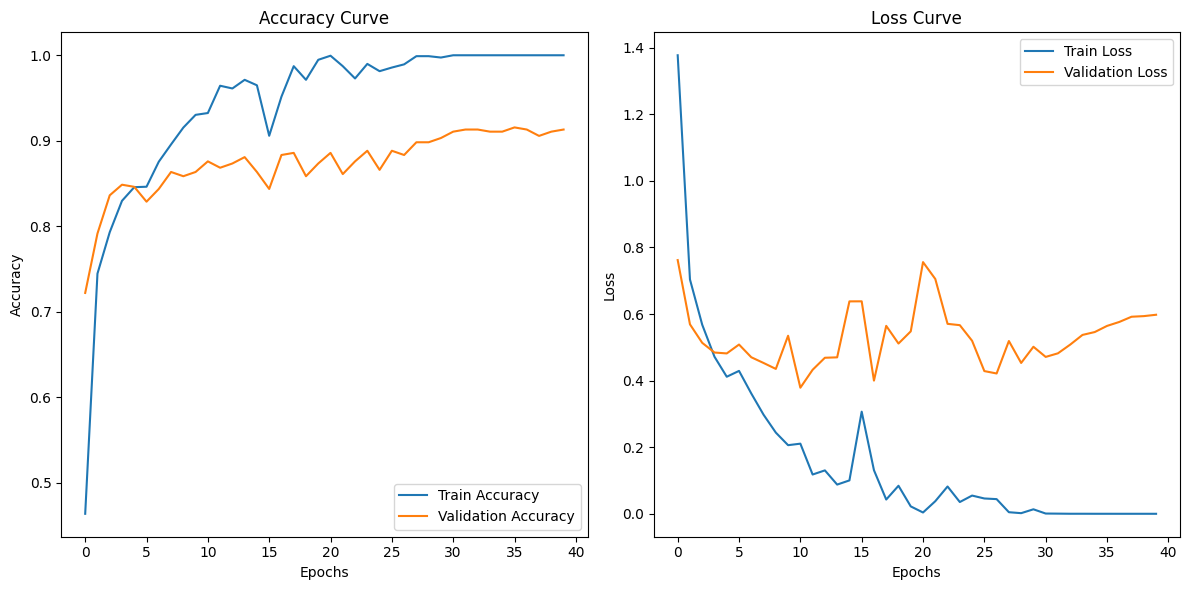

In [ ]:
#!/usr/bin/env python3

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image

# GPU configuration
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("Using GPU:", physical_devices[0].name)
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU found. Using CPU.")

# Load spectrograms from multiple datasets
dataset_dirs = [
    "audio_representations/spectrograms/",
    "audio_representations_Tess/spectrograms/"
    "audio_representations_RAVDESS/spectrograms/"
]

images = []
labels = []

# Sample 70% of the dataset to reduce RAM usage
sampling_rate = 0.5

for dataset_dir in dataset_dirs:
    # Get all image files
    all_files = [f for f in os.listdir(dataset_dir) if f.endswith(".png")]

    # Randomly sample files
    sampled_files = np.random.choice(
        all_files,
        size=int(len(all_files) * sampling_rate),
        replace=False
    )

    for file_name in sampled_files:
        file_path = os.path.join(dataset_dir, file_name)

        # Load and resize image
        img = Image.open(file_path).convert("RGB")
        img = img.resize((224, 224))  # VGG19 expects 224x224 input size
        img_array = np.array(img)
        images.append(img_array)

        # Extract label from filename's third value
        parts = file_name.split("-")
        if len(parts) >= 3:
            label_raw = int(parts[2]) - 1  # Adjusting to 0-based indexing
        else:
            print(f"Skipping file {file_name} - not enough parts")
            continue

        labels.append(label_raw)

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Normalize the images
images = images / 255.0

# One-hot encode labels
num_classes = len(np.unique(labels))
labels_one_hot = to_categorical(labels, num_classes=num_classes)

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels_one_hot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# VGG19 model setup
img_height, img_width = 224, 224
conv_base = VGG19(weights='imagenet', pooling='avg', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the first 12 layers of VGG19
for layer in conv_base.layers[:12]:
    layer.trainable = False

# Create model
model = models.Sequential([
    conv_base,
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Model compilation
learning_rate = 5e-5
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate), metrics=['accuracy'])

# Training
history = model.fit(X_train, y_train, batch_size=16,
                    epochs=40,
                    shuffle=True,
                    validation_data=(X_val, y_val),
                    callbacks=[ModelCheckpoint("vgg19_multi_dataset.keras", monitor='val_accuracy', save_best_only=True, mode='max')])

# Evaluation
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
%pwd
%ls

 audio_representations/   CNNBLSTM/           EXTRAS_MODELS/   PARALELLECNN/         VGG/
 CNN/                    'data management'/   LSTM/           'Results and plots'/


Using GPU: /physical_device:GPU:0
Training set: (1512, 224, 224, 3), (1512, 9)
Validation set: (324, 224, 224, 3), (324, 9)
Test set: (324, 224, 224, 3), (324, 9)
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 50s 358ms/step - accuracy: 0.1902 - loss: 2.1053 - val_accuracy: 0.3611 - val_loss: 1.5449
Epoch 2/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 20s 210ms/step - accuracy: 0.4414 - loss: 1.4166 - val_accuracy: 0.7099 - val_loss: 0.8487
Epoch 3/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 20s 214ms/step - accuracy: 0.6775 - loss: 0.8801 - val_accuracy: 0.7222 - val_loss: 0.7740
Epoch 4/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 21s 220ms/step - accuracy: 0.7050 - loss: 0.7951 - val_accuracy: 0.7840 - val_loss: 0.6401
Epoch 5/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 39s 199ms/step - accuracy: 0.7330 - loss: 0.7399 - val_accuracy: 0.7593 - val_loss: 0.6381
Epoch 6/40
95/95 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - accuracy: 0.7613 - loss: 0.6523 - val_accuracy: 0.7716 - val_loss: 0.6164
Epoch 7/40
9

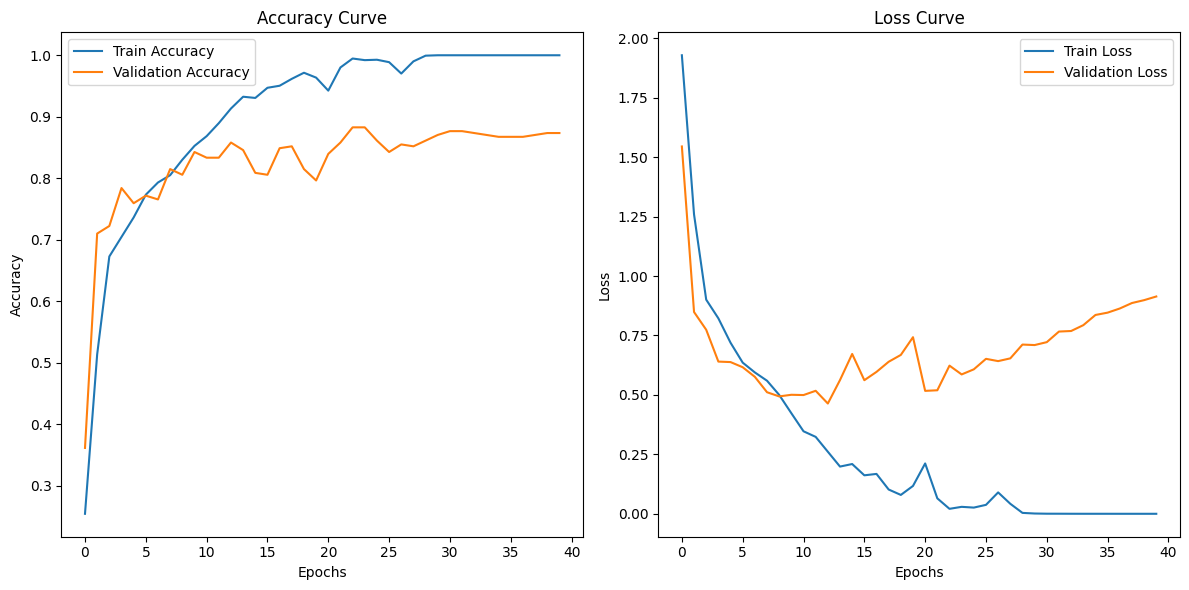

In [6]:
#!/usr/bin/env python3

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image

# GPU configuration
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("Using GPU:", physical_devices[0].name)
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU found. Using CPU.")

# Load spectrograms from multiple datasets
dataset_dirs = [
    "audio_representations/audio_representations_savee/spectrograms/",
    "audio_representations/audio_representations_Tess/spectrograms/",
    "audio_representations/audio_representations_ravdess/spectrograms/"
]

images = []
labels = []

# Sample 70% of the dataset to reduce RAM usage
sampling_rate = 0.5

for dataset_dir in dataset_dirs:
    # Get all image files
    all_files = [f for f in os.listdir(dataset_dir) if f.endswith(".png")]

    # Randomly sample files
    sampled_files = np.random.choice(
        all_files,
        size=int(len(all_files) * sampling_rate),
        replace=False
    )

    for file_name in sampled_files:
        file_path = os.path.join(dataset_dir, file_name)

        # Load and resize image
        img = Image.open(file_path).convert("RGB")
        img = img.resize((224, 224))  # VGG19 expects 224x224 input size
        img_array = np.array(img)
        images.append(img_array)

        # Extract label from filename's third value
        parts = file_name.split("-")
        if len(parts) >= 3:
            label_raw = int(parts[2]) - 1  # Adjusting to 0-based indexing
        else:
            print(f"Skipping file {file_name} - not enough parts")
            continue

        labels.append(label_raw)

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Normalize the images
images = images / 255.0

# One-hot encode labels
num_classes = len(np.unique(labels))
labels_one_hot = to_categorical(labels, num_classes=num_classes)

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels_one_hot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# VGG19 model setup
img_height, img_width = 224, 224
conv_base = VGG19(weights='imagenet', pooling='avg', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the first 12 layers of VGG19
for layer in conv_base.layers[:12]:
    layer.trainable = False

# Create model
model = models.Sequential([
    conv_base,
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Model compilation
learning_rate = 5e-5
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate), metrics=['accuracy'])

# Training
history = model.fit(X_train, y_train, batch_size=16,
                    epochs=40,
                    shuffle=True,
                    validation_data=(X_val, y_val),
                    callbacks=[ModelCheckpoint("vgg19_multi_dataset.keras", monitor='val_accuracy', save_best_only=True, mode='max')])

# Evaluation
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
model.save_weights('vgg19_model.weights.h5')


In [12]:
model.save('vgg19_complete_model.h5')


In [ ]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Chemin vers le dataset TESS
dataset_path = 'TESS'
output_dir = 'audio_representations_Tess/'

# Créer les dossiers pour les représentations
spectrograms_dir = os.path.join(output_dir, 'spectrograms')
mfcc_dir = os.path.join(output_dir, 'MFCCs')
os.makedirs(spectrograms_dir, exist_ok=True)
os.makedirs(mfcc_dir, exist_ok=True)

# Mapper les émotions TESS vers les codes RAVDESS
emotion_mapping = {
    "angry": "05",
    "disgust": "07",
    "fear": "06",
    "happy": "03",
    "neutral": "01",
    "pleasant_surprise": "08",
    "sad": "04",
}

# Fonction pour générer des spectrogrammes
def generate_spectrogram(y, sr, output_file):
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    plt.figure(figsize=(2.56, 2.56))
    plt.axis('off')
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.savefig(output_file, bbox_inches='tight', pad_inches=0)
    plt.close()

# Fonction pour générer des MFCCs
def generate_mfcc(y, sr, output_file, n_mfcc=13):
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    plt.figure(figsize=(2.56, 2.56))
    plt.axis('off')
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.savefig(output_file, bbox_inches='tight', pad_inches=0)
    plt.close()

# Charger et traiter les fichiers audio
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):  # Vérifie si c'est un dossier
        for file in os.listdir(folder_path):
            if file.endswith('.wav'):  # Vérifie si c'est un fichier audio
                file_path = os.path.join(folder_path, file)

                # Charger l'audio
                y, sr = librosa.load(file_path, sr=None)

                # Extraire les informations
                locutrice = folder.split('_')[0]  # OAF ou YAF
                emotion = folder.split('_')[1].lower()  # Emotion en minuscule

                # Récupérer le code RAVDESS pour l'émotion
                emotion_code = emotion_mapping.get(emotion, "00")  # 00 si inconnue

                # Nomenclature des fichiers de sortie
                # Format : 02-01-XX-01-01-01-01 où XX est le code de l'émotion
                base_filename = f"02-01-{emotion_code}-01-01-01-01"
                spectrogram_output = os.path.join(spectrograms_dir, f"{base_filename}.png")
                mfcc_output = os.path.join(mfcc_dir, f"{base_filename}.png")

                # Générer et sauvegarder les représentations
                generate_spectrogram(y, sr, spectrogram_output)
                generate_mfcc(y, sr, mfcc_output)

                print(f"Représentations générées pour {file}:")
                print(f"  - Spectrogramme: {spectrogram_output}")
                print(f"  - MFCCs: {mfcc_output}")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  - Spectrogramme: audio_representations_Tess/spectrograms/02-01-03-01-01-01-01.png
  - MFCCs: audio_representations_Tess/MFCCs/02-01-03-01-01-01-01.png
Représentations générées pour OAF_keep_happy.wav:
  - Spectrogramme: audio_representations_Tess/spectrograms/02-01-03-01-01-01-01.png
  - MFCCs: audio_representations_Tess/MFCCs/02-01-03-01-01-01-01.png
Représentations générées pour OAF_kill_happy.wav:
  - Spectrogramme: audio_representations_Tess/spectrograms/02-01-03-01-01-01-01.png
  - MFCCs: audio_representations_Tess/MFCCs/02-01-03-01-01-01-01.png
Représentations générées pour OAF_thumb_happy.wav:
  - Spectrogramme: audio_representations_Tess/spectrograms/02-01-03-01-01-01-01.png
  - MFCCs: audio_representations_Tess/MFCCs/02-01-03-01-01-01-01.png
Représentations générées pour OAF_live_happy.wav:
  - Spectrogramme: audio_representations_Tess/spectrograms/02-01-03-01-01-01-01.png
  - MFCCs: audio_represen

Using GPU: /physical_device:GPU:0
Training set: (1008, 224, 224, 3), (1008, 8)
Validation set: (216, 224, 224, 3), (216, 8)
Test set: (216, 224, 224, 3), (216, 8)
0 input_layer_3 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 True
13 block4_conv2 True
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True
22 global_average_pooling2d_1 True


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 512)                 │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,157,768 (76.90 MB)

 Trainable params: 17,832,200 (68.02 MB)

 Non-trainable params: 2,325,568 (8.87 MB)

Epoch 1/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.1610 - loss: 2.1362
Epoch 1: val_accuracy improved from -inf to 0.39352, saving model to vgg19_finetuned.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 364ms/step - accuracy: 0.1613 - loss: 2.1346 - val_accuracy: 0.3935 - val_loss: 1.8688
Epoch 2/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.3208 - loss: 1.7923
Epoch 2: val_accuracy improved from 0.39352 to 0.46759, saving model to vgg19_finetuned.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 215ms/step - accuracy: 0.3212 - loss: 1.7908 - val_accuracy: 0.4676 - val_loss: 1.4812
Epoch 3/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.4810 - loss: 1.4595
Epoch 3: val_accuracy improved from 0.46759 to 0.49074, saving model to vgg19_finetuned.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 293ms/step - accuracy: 0.4808 - loss: 1.4598 - val_accuracy: 0.4907 - val_loss: 1.3505
Epoch 4/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.4976 - loss: 1.3461
Epoch 4: val_accuracy i

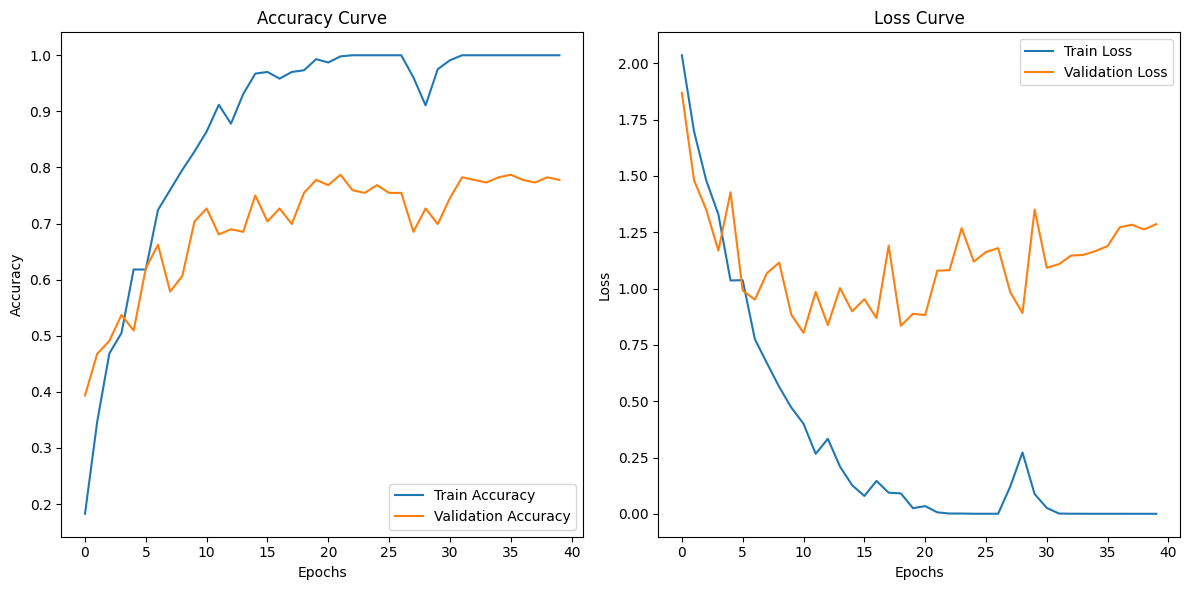

In [ ]:
#!/usr/bin/env python3

# Import required libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from PIL import Image

# Check if GPU is available and set TensorFlow to use it
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("Using GPU:", physical_devices[0].name)
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU found. Using CPU.")

# Load spectrograms or images
spectrograms_dir = "audio_representations/spectrograms"
images = []
labels = []

for file_name in os.listdir(spectrograms_dir):
    if file_name.endswith(".png"):
        file_path = os.path.join(spectrograms_dir, file_name)

        # Load and resize image
        img = Image.open(file_path).convert("RGB")
        img = img.resize((224, 224))  # VGG19 expects 224x224 input size
        img_array = np.array(img)
        images.append(img_array)

        # Extract label from filename (assuming labels are in the filename)
        label = int(file_name.split("-")[2]) - 1  # Adjusting to 0-based indexing
        labels.append(label)

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Normalize the images
images = images / 255.0

# One-hot encode labels
num_classes = len(np.unique(labels))
labels_one_hot = to_categorical(labels, num_classes=num_classes)

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels_one_hot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# Define the VGG19 base model
img_height, img_width = 224, 224  # Expected input size for VGG19
conv_base = VGG19(weights='imagenet', pooling='avg', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the first 12 layers of VGG19
for layer in conv_base.layers[:12]:
    layer.trainable = False

# Check which layers are frozen
for i, layer in enumerate(conv_base.layers):
    print(i, layer.name, layer.trainable)

# Create a new model
model = models.Sequential()
model.add(conv_base)
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))  # Increased dropout to prevent overfitting
model.add(Dense(num_classes, activation='softmax'))

# Display the model summary
model.summary()

# Define the ModelCheckpoint callback to save the best model
checkpointer = ModelCheckpoint("vgg19_finetuned.keras", monitor='val_accuracy', verbose=1,
                                save_best_only=True, mode='max')

# Compile the model
learning_rate = 5e-5  # Lower learning rate for fine-tuning
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate), metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, batch_size=16,
                    epochs=40,
                    shuffle=True,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpointer])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:
#!/usr/bin/env python3

# Import required libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
from PIL import Image

# Check if GPU is available and set TensorFlow to use it
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("Using GPU:", physical_devices[0].name)
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU found. Using CPU.")

# Load spectrograms or images
spectrograms_dir = "audio_representations/spectrograms"
images = []
labels = []

for file_name in os.listdir(spectrograms_dir):
    if file_name.endswith(".png"):
        file_path = os.path.join(spectrograms_dir, file_name)

        # Load and resize image
        img = Image.open(file_path).convert("RGB")
        img = img.resize((224, 224))  # VGG19 expects 224x224 input size
        img_array = np.array(img)
        images.append(img_array)

        # Extract label from filename (assuming labels are in the filename)
        label = int(file_name.split("-")[2]) - 1  # Adjusting to 0-based indexing
        labels.append(label)

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Normalize the images
images = images / 255.0

# One-hot encode labels
num_classes = len(np.unique(labels))
labels_one_hot = to_categorical(labels, num_classes=num_classes)

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels_one_hot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# Define the VGG19 base model
img_height, img_width = 224, 224  # Expected input size for VGG19
conv_base = VGG19(weights='imagenet', pooling='avg', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the first 12 layers of VGG19
for layer in conv_base.layers[:12]:
    layer.trainable = False

# Check which layers are frozen
for i, layer in enumerate(conv_base.layers):
    print(i, layer.name, layer.trainable)

# Create a new model
model = models.Sequential()
model.add(conv_base)
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))  # Increased dropout to prevent overfitting
model.add(Dense(num_classes, activation='softmax'))

# Display the model summary
model.summary()

# Uncomment below to train the model
"""
# Define the ModelCheckpoint callback to save the best model
checkpointer = ModelCheckpoint("vgg19_finetuned.keras", monitor='val_accuracy', verbose=1,
                                save_best_only=True, mode='max')

# Compile the model
learning_rate = 5e-5  # Lower learning rate for fine-tuning
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate), metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, batch_size=16,
                    epochs=40,
                    shuffle=True,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpointer])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
"""

# Visualize the architecture of the model
plot_model(
    model,
    to_file='model_architecture.png',  # Output file
    show_shapes=True,                  # Display tensor shapes
    show_layer_names=True,             # Display layer names
    expand_nested=True,                # Expand nested layers
    dpi=150                            # Image resolution
)

print("The model architecture has been saved as 'model_architecture.png'.")


Using GPU: /physical_device:GPU:0
Training set: (1008, 224, 224, 3), (1008, 8)
Validation set: (216, 224, 224, 3), (216, 8)
Test set: (216, 224, 224, 3), (216, 8)
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
0 input_layer False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 True
13 block4_conv2 True
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True
22 global_average_pooling2d True


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 512)                 │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,157,768 (76.90 MB)

 Trainable params: 17,832,200 (68.02 MB)

 Non-trainable params: 2,325,568 (8.87 MB)

The model architecture has been saved as 'model_architecture.png'.
